In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import wandb
from nam.utils.loggers import WandBLogger
from nam.config import defaults
from main import get_config

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, accuracy_score
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from loguru import logger

from nam.config import defaults
from nam.types import Config
from nam.utils.args import parse_args
from nam.data import NAMDataset
from nam.models import DNN, FeatureNN, NAM, get_num_units
from nam.engine import Engine

from main import get_config

import pytorch_lightning as pl

In [5]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from loguru import logger

from nam.config import defaults
from nam.types import Config
from nam.utils.args import parse_args
from nam.data import NAMDataset
from nam.models import DNN, FeatureNN, NAM, get_num_units
from nam.engine import Engine

from main import get_config

import pytorch_lightning as pl

In [6]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'training_epochs': {
            'values': [2, 5, 10, 50]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },
        'decay_rate': {
            'values': [0.0005, 0.005, 0.05]
        },
        'lr': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        },
        'activation': {
            'values': ['relu', 'exu']
        }
    }
}

In [7]:
sweep_id = wandb.sweep(sweep_config, entity="amrmkayid", project="nam")

Create sweep with ID: nt11q4wz
Sweep URL: https://wandb.ai/amrmkayid/nam/sweeps/nt11q4wz


In [8]:
def get_dataset(config, name='housing'):
    if name == 'housing':
        features_columns = [
        "longitude", "latitude", "housing_median_age", "total_rooms",
             "population", "households", "median_income", #"total_bedrooms",
        ]
        targets_column = ["median_house_value"]
        dataset = NAMDataset(config=config,
                            csv_file='data/housing.csv',
                            features_columns=features_columns,
                            targets_column=targets_column, 
                            one_hot=False)
        return dataset
    
    elif name == 'gallup':
        features_columns = ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"]
        targets_column = ["WP16"]
        weights_column = ["wgt"]
        
        data = pd.read_csv('data/GALLUP.csv')
        data = data.fillna(method='ffill')
        
        dataset = NAMDataset(config=config,
                    csv_file=data, #'data/GALLUP.csv',
                    features_columns=features_columns,
                    targets_column=targets_column,
                    weights_column=weights_column, 
                    #one_hot=True,
                    )
        return dataset
        

In [9]:
def train():
    config = get_config()
    
    logger = WandBLogger(configs=config)
    
    dataset = get_dataset(config, name='housing')


    train_dataset, test_dataset = torch.utils.data.random_split(
      dataset,
      [int(np.floor(len(dataset) * .9)),
       int(np.ceil(len(dataset) * .1))],
    )
#     print(len(train_dataset), len(test_dataset))

    train_dataset, val_dataset = torch.utils.data.random_split(
      train_dataset,
      [int(np.floor(len(train_dataset) * .8)),
       int(np.ceil(len(train_dataset) * .2))],
    )
#     print(len(train_dataset), len(val_dataset))

    train_dataloader = DataLoader(
      train_dataset,
      batch_size=config.batch_size,
      shuffle=True,
      num_workers=config.num_workers,
    )
    val_dataloader = DataLoader(
      val_dataset,
      batch_size=config.batch_size * 5,
      shuffle=False,
      num_workers=config.num_workers,
    )

#     if config.model == 'fnn':
#         fnn = FeatureNN(
#           config=config,
#           name=f'FeatureNN_{0}',
#           input_shape=next(iter(train_dataloader))[0].shape[-1],
#           num_units=128,
#         )
#     elif config.model == 'nam':
    model = NAM(
          config=config,
          name="NAMModel",
          num_inputs=len(dataset[0][0]),
          num_units=get_num_units(config, train_dataloader)
    )
        
    
    
    loss_obj = torch.nn.MSELoss()
    
    # Define the optimizer
    if config.optimizer=='sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
    elif config.optimizer=='rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config.lr)
    elif config.optimizer=='adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    
    
    
    logger.watch(model, log="all", log_freq=10)
    
    for i in range(config.training_epochs):
        optimizer.zero_grad()
        for X, y, *w in train_dataloader:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
            logger.write({'loss': loss.item()})
#         print(loss)

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: n63qi1w4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.4
wandb: 	lr: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	training_epochs: 10
wandb: Currently logged in as: amrmkayid (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


loss,28580450304.0
_runtime,20
_timestamp,1613226293
_step,149


loss,█▂▂▁▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bokzw63r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	decay_rate: 0.0005
wandb: 	dropout: 0.5
wandb: 	lr: 0.0003
wandb: 	optimizer: sgd
wandb: 	training_epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,34343669760.0
_runtime,22
_timestamp,1613226324
_step,149


loss,█▂▁▂▂▁▁▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6rwk99tv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.4
wandb: 	lr: 0.001
wandb: 	optimizer: adam
wandb: 	training_epochs: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,30507915264.0
_runtime,19
_timestamp,1613226350
_step,149


loss,█▂▂▂▁▂▁▁▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2mdpri83 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.3
wandb: 	lr: 0.0003
wandb: 	optimizer: sgd
wandb: 	training_epochs: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,27680620544.0
_runtime,19
_timestamp,1613226377
_step,149


loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 549q0e0f with config:
wandb: 	activation: exu
wandb: 	batch_size: 256
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.5
wandb: 	lr: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	training_epochs: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,28875114496.0
_runtime,19
_timestamp,1613226404
_step,149


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1uxjp2qw with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	decay_rate: 0.0005
wandb: 	dropout: 0.3
wandb: 	lr: 1e-05
wandb: 	optimizer: rmsprop
wandb: 	training_epochs: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,33837787136.0
_runtime,21
_timestamp,1613226435
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwjl5o8z with config:
wandb: 	activation: exu
wandb: 	batch_size: 32
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.5
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
wandb: 	training_epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,31103721472.0
_runtime,22
_timestamp,1613226475
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1uwwgpmn with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.4
wandb: 	lr: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	training_epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,31840651264.0
_runtime,20
_timestamp,1613226508
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7oa9x1x2 with config:
wandb: 	activation: exu
wandb: 	batch_size: 128
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.4
wandb: 	lr: 0.001
wandb: 	optimizer: adam
wandb: 	training_epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,33952153600.0
_runtime,21
_timestamp,1613226540
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g8kq755k with config:
wandb: 	activation: exu
wandb: 	batch_size: 32
wandb: 	decay_rate: 0.0005
wandb: 	dropout: 0.5
wandb: 	lr: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	training_epochs: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,30734055424.0
_runtime,20
_timestamp,1613226568
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h6tmnkmk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay_rate: 0.0005
wandb: 	dropout: 0.3
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
wandb: 	training_epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,35499204608.0
_runtime,21
_timestamp,1613226597
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: unvzukep with config:
wandb: 	activation: exu
wandb: 	batch_size: 256
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.4
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
wandb: 	training_epochs: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,37423661056.0
_runtime,20
_timestamp,1613226625
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: or9aoi3l with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.3
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
wandb: 	training_epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,30019194880.0
_runtime,21
_timestamp,1613226655
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ay4pkwb with config:
wandb: 	activation: exu
wandb: 	batch_size: 32
wandb: 	decay_rate: 0.0005
wandb: 	dropout: 0.5
wandb: 	lr: 3e-05
wandb: 	optimizer: rmsprop
wandb: 	training_epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,34977337344.0
_runtime,20
_timestamp,1613226694
_step,149


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k0ykmxrb with config:
wandb: 	activation: exu
wandb: 	batch_size: 32
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.3
wandb: 	lr: 3e-05
wandb: 	optimizer: adam
wandb: 	training_epochs: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


loss,40953880576.0
_runtime,20
_timestamp,1613226726
_step,149


loss,█▂▁▁▂▁▁▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f8w56bz5 with config:
wandb: 	activation: exu
wandb: 	batch_size: 128
wandb: 	decay_rate: 0.0005
wandb: 	dropout: 0.5
wandb: 	lr: 3e-05
wandb: 	optimizer: sgd
wandb: 	training_epochs: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep


---

In [90]:
config.n_models = 5

In [91]:
models = []
for n in range(config.n_models):
    models.append(NAM(
        config=config,
        name="NAMModel",
        num_inputs=X.shape[1],
        num_units=get_num_units(config, dataset_train)
    ))

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [92]:
for model in models:
    loss_obj = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for i in range(config.training_epochs):
        model.train()
        optimizer.zero_grad()
        for X, y in dataset_train:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
        print(loss)

tensor(272.8964, grad_fn=<MseLossBackward>)
tensor(117.9498, grad_fn=<MseLossBackward>)
tensor(114.6741, grad_fn=<MseLossBackward>)
tensor(103.4756, grad_fn=<MseLossBackward>)
tensor(84.6853, grad_fn=<MseLossBackward>)
tensor(65.7524, grad_fn=<MseLossBackward>)
tensor(53.5112, grad_fn=<MseLossBackward>)
tensor(48.9344, grad_fn=<MseLossBackward>)
tensor(51.1434, grad_fn=<MseLossBackward>)
tensor(55.4362, grad_fn=<MseLossBackward>)
tensor(55.5433, grad_fn=<MseLossBackward>)
tensor(52.1877, grad_fn=<MseLossBackward>)
tensor(48.0570, grad_fn=<MseLossBackward>)
tensor(45.5440, grad_fn=<MseLossBackward>)
tensor(45.6788, grad_fn=<MseLossBackward>)
tensor(47.1508, grad_fn=<MseLossBackward>)
tensor(48.2465, grad_fn=<MseLossBackward>)
tensor(47.8512, grad_fn=<MseLossBackward>)
tensor(46.3175, grad_fn=<MseLossBackward>)
tensor(44.7800, grad_fn=<MseLossBackward>)
tensor(44.1730, grad_fn=<MseLossBackward>)
tensor(44.5715, grad_fn=<MseLossBackward>)
tensor(45.1901, grad_fn=<MseLossBackward>)
tensor(

tensor(29.3878, grad_fn=<MseLossBackward>)
tensor(28.9748, grad_fn=<MseLossBackward>)
tensor(29.4418, grad_fn=<MseLossBackward>)
tensor(28.6210, grad_fn=<MseLossBackward>)
tensor(28.5112, grad_fn=<MseLossBackward>)
tensor(30.0876, grad_fn=<MseLossBackward>)
tensor(30.5246, grad_fn=<MseLossBackward>)
tensor(29.6598, grad_fn=<MseLossBackward>)
tensor(30.1106, grad_fn=<MseLossBackward>)
tensor(29.5290, grad_fn=<MseLossBackward>)
tensor(28.8341, grad_fn=<MseLossBackward>)
tensor(29.0354, grad_fn=<MseLossBackward>)
tensor(28.9283, grad_fn=<MseLossBackward>)
tensor(28.6928, grad_fn=<MseLossBackward>)
tensor(28.6860, grad_fn=<MseLossBackward>)
tensor(28.9142, grad_fn=<MseLossBackward>)
tensor(28.9405, grad_fn=<MseLossBackward>)
tensor(29.0880, grad_fn=<MseLossBackward>)
tensor(29.0292, grad_fn=<MseLossBackward>)
tensor(29.0320, grad_fn=<MseLossBackward>)
tensor(28.7439, grad_fn=<MseLossBackward>)
tensor(28.5065, grad_fn=<MseLossBackward>)
tensor(28.8029, grad_fn=<MseLossBackward>)
tensor(29.0

tensor(27.1962, grad_fn=<MseLossBackward>)
tensor(27.2349, grad_fn=<MseLossBackward>)
tensor(27.2377, grad_fn=<MseLossBackward>)
tensor(27.3171, grad_fn=<MseLossBackward>)
tensor(27.3341, grad_fn=<MseLossBackward>)
tensor(27.4480, grad_fn=<MseLossBackward>)
tensor(27.3277, grad_fn=<MseLossBackward>)
tensor(27.1942, grad_fn=<MseLossBackward>)
tensor(27.1431, grad_fn=<MseLossBackward>)
tensor(27.2301, grad_fn=<MseLossBackward>)
tensor(27.2767, grad_fn=<MseLossBackward>)
tensor(27.1882, grad_fn=<MseLossBackward>)
tensor(27.1064, grad_fn=<MseLossBackward>)
tensor(27.1209, grad_fn=<MseLossBackward>)
tensor(27.1881, grad_fn=<MseLossBackward>)
tensor(27.3141, grad_fn=<MseLossBackward>)
tensor(27.5480, grad_fn=<MseLossBackward>)
tensor(27.9923, grad_fn=<MseLossBackward>)
tensor(28.4903, grad_fn=<MseLossBackward>)
tensor(29.6594, grad_fn=<MseLossBackward>)
tensor(27.1693, grad_fn=<MseLossBackward>)
tensor(29.7954, grad_fn=<MseLossBackward>)
tensor(30.7564, grad_fn=<MseLossBackward>)
tensor(28.4

tensor(64.5079, grad_fn=<MseLossBackward>)
tensor(64.5666, grad_fn=<MseLossBackward>)
tensor(64.6401, grad_fn=<MseLossBackward>)
tensor(64.7079, grad_fn=<MseLossBackward>)
tensor(64.7464, grad_fn=<MseLossBackward>)
tensor(64.7523, grad_fn=<MseLossBackward>)
tensor(64.7151, grad_fn=<MseLossBackward>)
tensor(64.6530, grad_fn=<MseLossBackward>)
tensor(64.6182, grad_fn=<MseLossBackward>)
tensor(64.5442, grad_fn=<MseLossBackward>)
tensor(64.4522, grad_fn=<MseLossBackward>)
tensor(64.3515, grad_fn=<MseLossBackward>)
tensor(64.2543, grad_fn=<MseLossBackward>)
tensor(64.1592, grad_fn=<MseLossBackward>)
tensor(64.0538, grad_fn=<MseLossBackward>)
tensor(63.9748, grad_fn=<MseLossBackward>)
tensor(63.9199, grad_fn=<MseLossBackward>)
tensor(63.8545, grad_fn=<MseLossBackward>)
tensor(63.8088, grad_fn=<MseLossBackward>)
tensor(63.7790, grad_fn=<MseLossBackward>)
tensor(63.7516, grad_fn=<MseLossBackward>)
tensor(63.7220, grad_fn=<MseLossBackward>)
tensor(63.7072, grad_fn=<MseLossBackward>)
tensor(63.6

tensor(62.2593, grad_fn=<MseLossBackward>)
tensor(62.2553, grad_fn=<MseLossBackward>)
tensor(62.2500, grad_fn=<MseLossBackward>)
tensor(62.2487, grad_fn=<MseLossBackward>)
tensor(62.2421, grad_fn=<MseLossBackward>)
tensor(62.2390, grad_fn=<MseLossBackward>)
tensor(62.2350, grad_fn=<MseLossBackward>)
tensor(62.2284, grad_fn=<MseLossBackward>)
tensor(62.2218, grad_fn=<MseLossBackward>)
tensor(62.2167, grad_fn=<MseLossBackward>)
tensor(62.2142, grad_fn=<MseLossBackward>)
tensor(62.2124, grad_fn=<MseLossBackward>)
tensor(62.2049, grad_fn=<MseLossBackward>)
tensor(62.2042, grad_fn=<MseLossBackward>)
tensor(62.2018, grad_fn=<MseLossBackward>)
tensor(62.1959, grad_fn=<MseLossBackward>)
tensor(62.1890, grad_fn=<MseLossBackward>)
tensor(62.1835, grad_fn=<MseLossBackward>)
tensor(62.1799, grad_fn=<MseLossBackward>)
tensor(62.1805, grad_fn=<MseLossBackward>)
tensor(62.1772, grad_fn=<MseLossBackward>)
tensor(62.1695, grad_fn=<MseLossBackward>)
tensor(62.1689, grad_fn=<MseLossBackward>)
tensor(62.1

tensor(61.7700, grad_fn=<MseLossBackward>)
tensor(61.7686, grad_fn=<MseLossBackward>)
tensor(61.7666, grad_fn=<MseLossBackward>)
tensor(61.7641, grad_fn=<MseLossBackward>)
tensor(61.7629, grad_fn=<MseLossBackward>)
tensor(61.7609, grad_fn=<MseLossBackward>)
tensor(61.7588, grad_fn=<MseLossBackward>)
tensor(61.7568, grad_fn=<MseLossBackward>)
tensor(61.7548, grad_fn=<MseLossBackward>)
tensor(61.7525, grad_fn=<MseLossBackward>)
tensor(61.7510, grad_fn=<MseLossBackward>)
tensor(61.7505, grad_fn=<MseLossBackward>)
tensor(61.7474, grad_fn=<MseLossBackward>)
tensor(61.7469, grad_fn=<MseLossBackward>)
tensor(61.7441, grad_fn=<MseLossBackward>)
tensor(61.7424, grad_fn=<MseLossBackward>)
tensor(61.7403, grad_fn=<MseLossBackward>)
tensor(61.7382, grad_fn=<MseLossBackward>)
tensor(61.7364, grad_fn=<MseLossBackward>)
tensor(61.7341, grad_fn=<MseLossBackward>)
tensor(61.7330, grad_fn=<MseLossBackward>)
tensor(61.7308, grad_fn=<MseLossBackward>)
tensor(61.7293, grad_fn=<MseLossBackward>)
tensor(61.7

tensor(47.1369, grad_fn=<MseLossBackward>)
tensor(47.1702, grad_fn=<MseLossBackward>)
tensor(47.1862, grad_fn=<MseLossBackward>)
tensor(47.1791, grad_fn=<MseLossBackward>)
tensor(47.1527, grad_fn=<MseLossBackward>)
tensor(47.1170, grad_fn=<MseLossBackward>)
tensor(47.1459, grad_fn=<MseLossBackward>)
tensor(47.0913, grad_fn=<MseLossBackward>)
tensor(47.0999, grad_fn=<MseLossBackward>)
tensor(47.1080, grad_fn=<MseLossBackward>)
tensor(47.1035, grad_fn=<MseLossBackward>)
tensor(47.0871, grad_fn=<MseLossBackward>)
tensor(47.0714, grad_fn=<MseLossBackward>)
tensor(47.0736, grad_fn=<MseLossBackward>)
tensor(47.0698, grad_fn=<MseLossBackward>)
tensor(47.0516, grad_fn=<MseLossBackward>)
tensor(47.0607, grad_fn=<MseLossBackward>)
tensor(47.0387, grad_fn=<MseLossBackward>)
tensor(47.0445, grad_fn=<MseLossBackward>)
tensor(47.0336, grad_fn=<MseLossBackward>)
tensor(47.0260, grad_fn=<MseLossBackward>)
tensor(47.0284, grad_fn=<MseLossBackward>)
tensor(47.0134, grad_fn=<MseLossBackward>)
tensor(47.0

tensor(46.9359, grad_fn=<MseLossBackward>)
tensor(46.9351, grad_fn=<MseLossBackward>)
tensor(46.9346, grad_fn=<MseLossBackward>)
tensor(46.9336, grad_fn=<MseLossBackward>)
tensor(46.9328, grad_fn=<MseLossBackward>)
tensor(46.9322, grad_fn=<MseLossBackward>)
tensor(46.9315, grad_fn=<MseLossBackward>)
tensor(46.9310, grad_fn=<MseLossBackward>)
tensor(46.9301, grad_fn=<MseLossBackward>)
tensor(46.9292, grad_fn=<MseLossBackward>)
tensor(46.9286, grad_fn=<MseLossBackward>)
tensor(46.9280, grad_fn=<MseLossBackward>)
tensor(46.9275, grad_fn=<MseLossBackward>)
tensor(46.9265, grad_fn=<MseLossBackward>)
tensor(46.9260, grad_fn=<MseLossBackward>)
tensor(46.9253, grad_fn=<MseLossBackward>)
tensor(46.9240, grad_fn=<MseLossBackward>)
tensor(46.9234, grad_fn=<MseLossBackward>)
tensor(46.9229, grad_fn=<MseLossBackward>)
tensor(46.9226, grad_fn=<MseLossBackward>)
tensor(46.9217, grad_fn=<MseLossBackward>)
tensor(46.9211, grad_fn=<MseLossBackward>)
tensor(46.9204, grad_fn=<MseLossBackward>)
tensor(46.9

tensor(109.9008, grad_fn=<MseLossBackward>)
tensor(109.0861, grad_fn=<MseLossBackward>)
tensor(108.3518, grad_fn=<MseLossBackward>)
tensor(107.6054, grad_fn=<MseLossBackward>)
tensor(106.7730, grad_fn=<MseLossBackward>)
tensor(105.8595, grad_fn=<MseLossBackward>)
tensor(104.8027, grad_fn=<MseLossBackward>)
tensor(103.6184, grad_fn=<MseLossBackward>)
tensor(105.0457, grad_fn=<MseLossBackward>)
tensor(101.7325, grad_fn=<MseLossBackward>)
tensor(101.0366, grad_fn=<MseLossBackward>)
tensor(100.2184, grad_fn=<MseLossBackward>)
tensor(99.3703, grad_fn=<MseLossBackward>)
tensor(98.3141, grad_fn=<MseLossBackward>)
tensor(97.3516, grad_fn=<MseLossBackward>)
tensor(96.4727, grad_fn=<MseLossBackward>)
tensor(95.5755, grad_fn=<MseLossBackward>)
tensor(94.7296, grad_fn=<MseLossBackward>)
tensor(93.7102, grad_fn=<MseLossBackward>)
tensor(92.6895, grad_fn=<MseLossBackward>)
tensor(91.5241, grad_fn=<MseLossBackward>)
tensor(91.7821, grad_fn=<MseLossBackward>)
tensor(89.7106, grad_fn=<MseLossBackward>)

tensor(51.6441, grad_fn=<MseLossBackward>)
tensor(52.1636, grad_fn=<MseLossBackward>)
tensor(51.5615, grad_fn=<MseLossBackward>)
tensor(51.9060, grad_fn=<MseLossBackward>)
tensor(52.0916, grad_fn=<MseLossBackward>)
tensor(51.8959, grad_fn=<MseLossBackward>)
tensor(51.7342, grad_fn=<MseLossBackward>)
tensor(51.7667, grad_fn=<MseLossBackward>)
tensor(51.6142, grad_fn=<MseLossBackward>)
tensor(51.6486, grad_fn=<MseLossBackward>)
tensor(51.6363, grad_fn=<MseLossBackward>)
tensor(51.5227, grad_fn=<MseLossBackward>)
tensor(51.5090, grad_fn=<MseLossBackward>)
tensor(51.3857, grad_fn=<MseLossBackward>)
tensor(51.3773, grad_fn=<MseLossBackward>)
tensor(51.1513, grad_fn=<MseLossBackward>)
tensor(51.4035, grad_fn=<MseLossBackward>)
tensor(51.2614, grad_fn=<MseLossBackward>)
tensor(51.0855, grad_fn=<MseLossBackward>)
tensor(51.1193, grad_fn=<MseLossBackward>)
tensor(51.0595, grad_fn=<MseLossBackward>)
tensor(51.2174, grad_fn=<MseLossBackward>)
tensor(51.2325, grad_fn=<MseLossBackward>)
tensor(51.3

tensor(50.4156, grad_fn=<MseLossBackward>)
tensor(50.4095, grad_fn=<MseLossBackward>)
tensor(50.4016, grad_fn=<MseLossBackward>)
tensor(50.3960, grad_fn=<MseLossBackward>)
tensor(50.3566, grad_fn=<MseLossBackward>)
tensor(50.4373, grad_fn=<MseLossBackward>)
tensor(50.4142, grad_fn=<MseLossBackward>)
tensor(50.3619, grad_fn=<MseLossBackward>)
tensor(50.3935, grad_fn=<MseLossBackward>)
tensor(50.3784, grad_fn=<MseLossBackward>)
tensor(50.4152, grad_fn=<MseLossBackward>)
tensor(50.3441, grad_fn=<MseLossBackward>)
tensor(50.3669, grad_fn=<MseLossBackward>)
tensor(50.1561, grad_fn=<MseLossBackward>)
tensor(50.2625, grad_fn=<MseLossBackward>)
tensor(50.3121, grad_fn=<MseLossBackward>)
tensor(50.4358, grad_fn=<MseLossBackward>)
tensor(50.5195, grad_fn=<MseLossBackward>)
tensor(50.4654, grad_fn=<MseLossBackward>)
tensor(50.2390, grad_fn=<MseLossBackward>)
tensor(50.3589, grad_fn=<MseLossBackward>)
tensor(50.1819, grad_fn=<MseLossBackward>)
tensor(50.2326, grad_fn=<MseLossBackward>)
tensor(50.2

tensor(59.9768, grad_fn=<MseLossBackward>)
tensor(59.9659, grad_fn=<MseLossBackward>)
tensor(59.8721, grad_fn=<MseLossBackward>)
tensor(59.9042, grad_fn=<MseLossBackward>)
tensor(59.8142, grad_fn=<MseLossBackward>)
tensor(59.8305, grad_fn=<MseLossBackward>)
tensor(59.8289, grad_fn=<MseLossBackward>)
tensor(59.7168, grad_fn=<MseLossBackward>)
tensor(59.6914, grad_fn=<MseLossBackward>)
tensor(59.6514, grad_fn=<MseLossBackward>)
tensor(59.7360, grad_fn=<MseLossBackward>)
tensor(59.6417, grad_fn=<MseLossBackward>)
tensor(59.5069, grad_fn=<MseLossBackward>)
tensor(59.8106, grad_fn=<MseLossBackward>)
tensor(59.5199, grad_fn=<MseLossBackward>)
tensor(59.8734, grad_fn=<MseLossBackward>)
tensor(59.8112, grad_fn=<MseLossBackward>)
tensor(59.5123, grad_fn=<MseLossBackward>)
tensor(59.8609, grad_fn=<MseLossBackward>)
tensor(59.6609, grad_fn=<MseLossBackward>)
tensor(59.5751, grad_fn=<MseLossBackward>)
tensor(59.6976, grad_fn=<MseLossBackward>)
tensor(59.4245, grad_fn=<MseLossBackward>)
tensor(59.4

tensor(54.9571, grad_fn=<MseLossBackward>)
tensor(54.9658, grad_fn=<MseLossBackward>)
tensor(54.8781, grad_fn=<MseLossBackward>)
tensor(54.9467, grad_fn=<MseLossBackward>)
tensor(54.9534, grad_fn=<MseLossBackward>)
tensor(54.7358, grad_fn=<MseLossBackward>)
tensor(54.9576, grad_fn=<MseLossBackward>)
tensor(54.8180, grad_fn=<MseLossBackward>)
tensor(54.6363, grad_fn=<MseLossBackward>)
tensor(54.8081, grad_fn=<MseLossBackward>)
tensor(54.5921, grad_fn=<MseLossBackward>)
tensor(54.6016, grad_fn=<MseLossBackward>)
tensor(54.6936, grad_fn=<MseLossBackward>)
tensor(54.4227, grad_fn=<MseLossBackward>)
tensor(54.4344, grad_fn=<MseLossBackward>)
tensor(54.3349, grad_fn=<MseLossBackward>)
tensor(54.3897, grad_fn=<MseLossBackward>)
tensor(54.2372, grad_fn=<MseLossBackward>)
tensor(54.4454, grad_fn=<MseLossBackward>)
tensor(54.3230, grad_fn=<MseLossBackward>)
tensor(54.2710, grad_fn=<MseLossBackward>)
tensor(54.5483, grad_fn=<MseLossBackward>)
tensor(54.0366, grad_fn=<MseLossBackward>)
tensor(54.2

In [93]:
for model in models:
    y_pred = model(X_test)
    y_test_numpy = y_test.detach().numpy()
    y_pred_numpy = y_pred.detach().numpy()
    print(r2_score(y_test_numpy, y_pred_numpy))

0.7817431196993259
0.17428314137621592
0.4264644583927174
0.40957413280092336
0.23999656043554618


In [94]:
import nam.utils.graphing as graphing

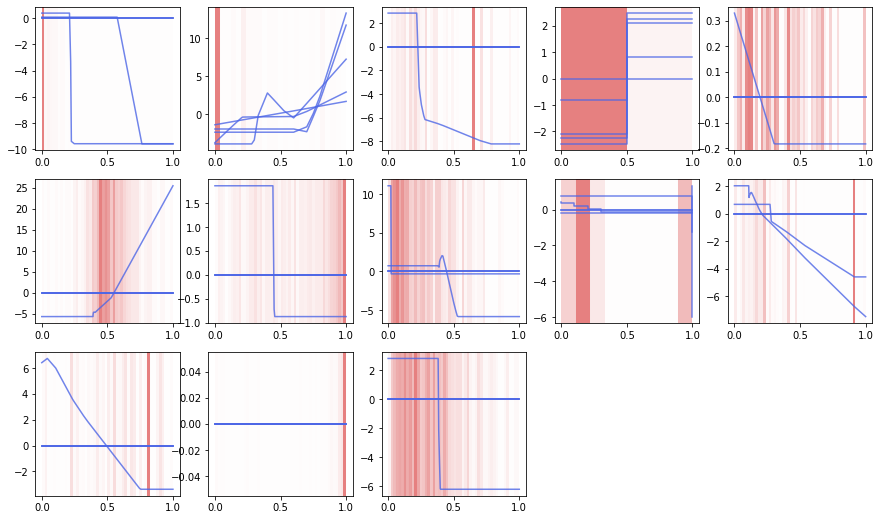

In [95]:
graphing.nam_plot(X_train, models)